In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import mne
from collections import defaultdict 
import re

In [2]:
%matplotlib notebook

# Load Data from an Intan RHD file.
### Header information (and saved data, if present) will be stored in the *result* variable. You'll also be able to specify a channel's name to plot its recorded data as an example of accessing data from *result*.

In [3]:
# Load the background Python functions that allow for data loading and plotting
%run importrhdutilities.py

### Name of file to load. To load a different file, move it to the same directory as this notebook, and change the following 'filename' variable to point the name of your file.

In [18]:
metadata = pd.read_csv('./data/channel_mapping.csv')

In [19]:
metadata

,Channel Number,Color of Cables,Coordinate,Region,Purpose
0,13,Yellow,ML-5.38 AP+1.16,S1ULp,"Should be right whiskers, error on drilling"
1,14,Orange,ML-2 AP2,Edge of FrA and cc,"Not designed for this, error on drilling"
2,16,Blue,ML-2 AP-1.5,S1HL,Right foot
3,17,Red,ML+3 AP+5,FrA,Possible Ref
4,19,Black,ML+5 AP-2.5,S1BF,Left whiskers


In [7]:
# Coordinates from the table (converted to meters)
rat_channel_data = [
    {"name": "13", "ml": -5.38 / 100, "ap": 1.16 / 100, "dv": 0.0},  # S1ULp
    {"name": "14", "ml": -2.0 / 100, "ap": 2.0 / 100, "dv": 0.0},    # FrA and cc
    {"name": "16", "ml": -2.0 / 100, "ap": -1.5 / 100, "dv": 0.0},   # S1HL
    {"name": "17", "ml": 3.0 / 100, "ap": 5.0 / 100, "dv": 0.0},     # FrA (Possible Ref)
    {"name": "19", "ml": 5.0 / 100, "ap": -2.5 / 100, "dv": 0.0},    # S1BF
]


/tmp/ipykernel_31322/3093049160.py:8: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  montage.plot(kind="topomap", show=True)


<IPython.core.display.Javascript object>

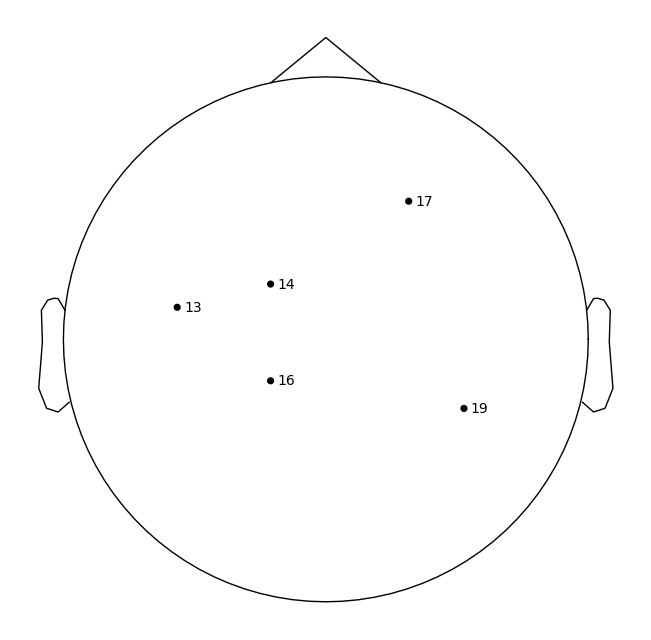

In [8]:
# Create channel positions dictionary
ch_pos = {f"{name['name']}": [name["ml"], name["ap"], name["dv"]] for name in rat_channel_data}

# Create montage (coord_frame='unknown' for non-human data)
montage = mne.channels.make_dig_montage(ch_pos=ch_pos, coord_frame="unknown")

# Visualize the montage
montage.plot(kind="topomap", show=True)

In [51]:
recording_notes = pd.read_csv('./data/recording_notes.csv')

In [52]:
# Function to convert MM:SS to seconds
def mmss_to_seconds(value):
    if ':' in value:
        minutes, seconds = map(int, value.split(':'))
        return minutes * 60 + seconds
    return int(value)  # If the value is already in seconds

# Function to extract tuples and handle MM:SS conversion
def extract_tuples(cell):
    try:
        if isinstance(cell, str):
            # Match all ranges in the format "start-end stim" with optional MM:SS format
            matches = re.findall(r"([\d:]+)-([\d:]+)", cell)
            # Convert matches to tuples of integers in seconds
            return [(mmss_to_seconds(start), mmss_to_seconds(end)) for start, end in matches]
        else:
            return np.nan  # Return NaN if cell is not a string
    except:
        return np.nan  # Return NaN if any error occurs


In [53]:
# Apply the function to the column
recording_notes["Stimulation Tuples"] = recording_notes["Stimulation Time"].apply(extract_tuples)

In [54]:
recording_notes

,# of Test,Duration,Action,Notes,Stimulation Time,Stimulation Tuples
0,2,90s,Silence; Hardware ref 002,NaN,NaN,NaN
1,3,90s,Silence; AVG ref 003,NaN,NaN,NaN
2,4,90s,"Whisker 2 sides, stir+ clamp+light pull 004",wait 10s and then start 5s +5s rest keep until...,10-15 stim; 20-25 stim; 30-35 stim; 40-45 stim...,"[(10, 15), (20, 25), (30, 35), (40, 45), (50, ..."
3,5,60s,Silence avg ref 005,NaN,NaN,NaN
4,6,90s,Foot pinch 006,"Wait 10s, then foot pinch once at 11s, then 16...",16-20 stim; 26-30 stim; 36-40 stim; 46-50 stim...,"[(16, 20), (26, 30), (36, 40), (46, 50), (56, ..."
5,7,106s,Silence 007,NaN,NaN,NaN
6,8,102s,Whisker 008,"Wait 10s, 10-15 stim; 45-50stim; 1:30-1:35 sti...",10-15 stim; 45-50 stim; 1:30-1:35 stim,"[(10, 15), (45, 50), (90, 95)]"
7,9,30s,Silence 009,NaN,NaN,NaN
8,10,90s,Silence; Add more blank channels 010,"Ch0: no headstage; ch20-23: no pins out, but o...",NaN,NaN
9,11,90s,Foot pinch011,"Wait 10s, 10-15stim 45-50stim 1:30-1:35 stim O...",10-15 stim; 45-50 stim; 1:30-1:35 stim,"[(10, 15), (45, 50), (90, 95)]"


In [11]:
eeg_files = sorted(glob.glob('./data/0121_experiment_intan/**/*.rhd', recursive=True))

In [12]:
eeg_files

['./data/0121_experiment_intan/0121/001_250121_160632/001_250121_160632.rhd',
 './data/0121_experiment_intan/0121/002_250121_174234/002_250121_174234.rhd',
 './data/0121_experiment_intan/0121/003_250121_175015/003_250121_175015.rhd',
 './data/0121_experiment_intan/0121/004_250121_175353/004_250121_175353.rhd',
 './data/0121_experiment_intan/0121/005_250121_175739/005_250121_175739.rhd',
 './data/0121_experiment_intan/0121/006_250121_175954/006_250121_175954.rhd',
 './data/0121_experiment_intan/0121/007_250121_180405/007_250121_180405.rhd',
 './data/0121_experiment_intan/0121/007_250121_180605/007_250121_180605.rhd',
 './data/0121_experiment_intan/0121/008_250121_180703/008_250121_180703.rhd',
 './data/0121_experiment_intan/0121/009_250121_181000/009_250121_181000.rhd',
 './data/0121_experiment_intan/0121/010_250121_181133/010_250121_181133.rhd',
 './data/0121_experiment_intan/0121/011_250121_181412/011_250121_181412.rhd',
 './data/0121_experiment_intan/0121/012_250121_181646/012_250121

- Loading in the data

In [14]:
from mne.time_frequency import tfr_morlet

In [55]:
recording_notes

,# of Test,Duration,Action,Notes,Stimulation Time,Stimulation Tuples
0,2,90s,Silence; Hardware ref 002,NaN,NaN,NaN
1,3,90s,Silence; AVG ref 003,NaN,NaN,NaN
2,4,90s,"Whisker 2 sides, stir+ clamp+light pull 004",wait 10s and then start 5s +5s rest keep until...,10-15 stim; 20-25 stim; 30-35 stim; 40-45 stim...,"[(10, 15), (20, 25), (30, 35), (40, 45), (50, ..."
3,5,60s,Silence avg ref 005,NaN,NaN,NaN
4,6,90s,Foot pinch 006,"Wait 10s, then foot pinch once at 11s, then 16...",16-20 stim; 26-30 stim; 36-40 stim; 46-50 stim...,"[(16, 20), (26, 30), (36, 40), (46, 50), (56, ..."
5,7,106s,Silence 007,NaN,NaN,NaN
6,8,102s,Whisker 008,"Wait 10s, 10-15 stim; 45-50stim; 1:30-1:35 sti...",10-15 stim; 45-50 stim; 1:30-1:35 stim,"[(10, 15), (45, 50), (90, 95)]"
7,9,30s,Silence 009,NaN,NaN,NaN
8,10,90s,Silence; Add more blank channels 010,"Ch0: no headstage; ch20-23: no pins out, but o...",NaN,NaN
9,11,90s,Foot pinch011,"Wait 10s, 10-15stim 45-50stim 1:30-1:35 stim O...",10-15 stim; 45-50 stim; 1:30-1:35 stim,"[(10, 15), (45, 50), (90, 95)]"


In [41]:

from collections import defaultdict
import os
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet
import numpy as np

In [49]:
file_base

'006_250121_175954'

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import numpy as np

index_to_data = defaultdict(dict)
initial_offset = 5  # Initial offset in seconds


# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]

    try:
        # Extract numeric recording number from file name (e.g., "006_250121_175954" → 6)
        recording_number = int(file_base.split('_')[0])

        # Find the matching row in the DataFrame
        row = recording_notes[recording_notes["# of Test"] == recording_number]

        if row.empty:
            print(f"No stimulation data for recording {recording_number}")
            stimulation_times = None
        else:
            stimulation_times = row["Stimulation Tuples"].values[0]  # Extract tuple list

        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 15:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=initial_offset, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.notch_filter(60)  # Notch filter at 60 Hz
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot each channel in a separate subplot
        n_channels = len(filtered_channel_list)
        fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

        for i, ax in enumerate(axs):
            ax.plot(times + initial_offset, data[i], label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)
            ax.set_ylabel("Amplitude (µV)")
            ax.legend(loc="upper right")
            ax.grid(True)

            # Shade stimulation times if available
            if stimulation_times is not None and isinstance(stimulation_times, list):
                for (start, end) in stimulation_times:
                    ax.axvspan(start, end, color="orange", alpha=0.3)

            if i == 0:
                ax.set_title(f"EEG Time Series - {file_base}")

        axs[-1].set_xlabel("Time (s)")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_separate_channels_{file_base}.png", dpi=300)
        plt.show()  # Display the plot


        # Save PSD plot
        fig_psd = raw.plot_psd(fmin=2, fmax=70, average=False, spatial_colors=True, show=False)
        fig_psd.savefig(f"./plots/raw_psd_{file_base}.png", dpi=300)

        # ICA artifact removal
        ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
        ica.fit(raw)
        ica.exclude = [0, 1]  # Exclude identified artifact components
        raw_ica = ica.apply(raw.copy())

        # Save ICA component plot
        fig_ica = ica.plot_components(show=False)
        fig_ica.savefig(f"./plots/ica_components_{file_base}.png", dpi=300)

        # Save TFR plot for the first channel
        frequencies = np.arange(1, 20, 1)
        n_cycles = frequencies / 2
        power = tfr_morlet(raw_ica, freqs=frequencies, n_cycles=n_cycles, return_itc=False)
        fig_tfr = power.plot([0], baseline=(None, 0), mode='logratio', title=f'TFR - Channel {filtered_channel_list[0]}', show=False)
        fig_tfr.savefig(f"./plots/tfr_channel_{filtered_channel_list[0]}_{file_base}.png", dpi=300)

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files



Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 95.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.7 seconds
Creating RawArray with float64 data, n_channels=5, n_times=2878208
    Range : 0 ... 2878207 =      0.000 ...    95.940 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming 

/tmp/ipykernel_31322/2804704545.py:51: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)



<IPython.core.display.Javascript object>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


<IPython.core.display.Javascript object>

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
inst is Evoked, setting `average=False`
Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>

Error loading ./data/0121_experiment_intan/0121/006_250121_175954/006_250121_175954.rhd: 'list' object has no attribute 'savefig'


In [ ]:
raise ValueError()

In [48]:
import matplotlib.pyplot as plt
from collections import defaultdict

index_to_data = defaultdict(dict)
initial_offset = 5  # Initial offset in seconds

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 15:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=initial_offset, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.notch_filter(60)  # Notch filter at 60 Hz
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot each channel in a separate subplot
        n_channels = len(filtered_channel_list)
        fig, axs = plt.subplots(n_channels, 1, figsize=(16, 2 * n_channels), sharex=True)

        for i, ax in enumerate(axs):
            ax.plot(times + initial_offset, data[i], label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)
            ax.set_ylabel("Amplitude (µV)")
            ax.legend(loc="upper right")
            ax.grid(True)
            if i == 0:
                ax.set_title(f"EEG Time Series - {file_base}")

        axs[-1].set_xlabel("Time (s)")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_separate_channels_{file_base}.png", dpi=300)
        plt.show()  # Display the plot

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files



Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 95.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.8 seconds
Creating RawArray with float64 data, n_channels=5, n_times=2878208
    Range : 0 ... 2878207 =      0.000 ...    95.940 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming 

/tmp/ipykernel_31322/2300377054.py:35: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 99001 samples (3.300 s)



<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

index_to_data = defaultdict(dict)

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Crop the first and last 5 seconds
        duration = raw.times[-1]  # Total duration of the recording
        if duration > 15:  # Ensure at least 10 seconds remain after cropping
            raw.crop(tmin=5, tmax=duration - 10)
        else:
            print(f"File {file_base} too short after cropping.")
            continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot all channels using Matplotlib
        plt.figure(figsize=(16, 10))
        for i, channel_data in enumerate(data):
            plt.plot(times + 5, channel_data, label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)

        plt.title(f"EEG Time Series - {file_base}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_all_channels_{file_base}.png", dpi=300)
        plt.show()  # Display the plot

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files


Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 95.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.9 seconds
Creating RawArray with float64 data, n_channels=5, n_times=2878208
    Range : 0 ... 2878207 =      0.000 ...    95.940 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

/tmp/ipykernel_31322/683397198.py:34: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<IPython.core.display.Javascript object>

In [45]:
duration

np.float64(95.94023333333334)

In [44]:
channel_data

array([ 1.52107628,  9.85745607, 16.90880105, ..., 78.67735377,
       66.9993926 , 41.48140207], shape=(21485,))

In [42]:
index_to_data = defaultdict(dict)

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Extract data and time points for plotting
        data = raw.get_data()  # Shape: (n_channels, n_times)
        times = raw.times  # Time points in seconds

        # Plot all channels using Matplotlib
        plt.figure(figsize=(16, 10))
        for i, channel_data in enumerate(data):
            plt.plot(times, channel_data + i * 50e-6, label=f"Channel: {filtered_channel_list[i]}", alpha=0.8)
            # `i * 50e-6` offsets each channel vertically for better visualization

        plt.title(f"EEG Time Series - {file_base}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (µV)")
        plt.grid(True)
        plt.legend(loc="upper right")
        plt.tight_layout()

        # Save the plot to a file
        plt.savefig(f"./plots/timeseries_all_channels_{file_base}.png")
        plt.show()  # Display the plot

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break  # Remove or modify the break to process all files


Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 95.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.8 seconds
Creating RawArray with float64 data, n_channels=5, n_times=2878208
    Range : 0 ... 2878207 =      0.000 ...    95.940 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

/tmp/ipykernel_31322/1362481062.py:23: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<IPython.core.display.Javascript object>

In [ ]:


index_to_data = defaultdict(dict)

# Processing each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # Extract channel names and sample rate
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]

        # Find indices of valid channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]
        filtered_data = result["amplifier_data"][valid_indices]
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        # Create MNE Info and RawArray
        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')
        raw = mne.io.RawArray(filtered_data, info)

        # # Skip short recordings
        # if raw.times[-1] < 30:
        #     continue

        # Apply montage
        raw.set_montage(montage)

        # Preprocessing: Filter and downsample
        raw.filter(l_freq=1.0, h_freq=30.0)
        raw.resample(250, npad='auto')

        # Save raw time-series plot
        fig = raw.plot(scalings=dict(eeg=200e-6), show=False)
        fig.savefig(f"./plots/raw_timeseries_{file_base}.png", dpi=300)


        

        # Save PSD plot
        fig_psd = raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True, show=False)
        fig_psd.savefig(f"./plots/raw_psd_{file_base}.png", dpi=300)

        # ICA artifact removal
        ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
        ica.fit(raw)
        ica.exclude = [0, 1]  # Exclude identified artifact components
        raw_ica = ica.apply(raw.copy())

        # Save ICA component plot
        fig_ica = ica.plot_components(show=False)
        fig_ica.savefig(f"./plots/ica_components_{file_base}.png", dpi=300)

        # Save TFR plot for the first channel
        frequencies = np.arange(1, 20, 1)
        n_cycles = frequencies / 2
        power = tfr_morlet(raw_ica, freqs=frequencies, n_cycles=n_cycles, return_itc=False)
        fig_tfr = power.plot([0], baseline=(None, 0), mode='logratio', title=f'TFR - Channel {filtered_channel_list[0]}', show=False)
        fig_tfr.savefig(f"./plots/tfr_channel_{filtered_channel_list[0]}_{file_base}.png", dpi=300)

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    break



Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 95.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.6 seconds
Creating RawArray with float64 data, n_channels=5, n_times=2878208
    Range : 0 ... 2878207 =      0.000 ...    95.940 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming w

/tmp/ipykernel_31322/604617313.py:34: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<IPython.core.display.Javascript object>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


<IPython.core.display.Javascript object>

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
inst is Evoked, setting `average=False`
Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>

Error loading ./data/0121_experiment_intan/0121/006_250121_175954/006_250121_175954.rhd: 'list' object has no attribute 'savefig'


In [ ]:
index_to_data = defaultdict(dict)
# Looking at each file
for file_path in eeg_files[5:]:
    file_base = os.path.splitext(os.path.basename(file_path))[0]
    try:
        result, data_present = load_file(file_path)

        # all_channels = [(index, dictionary["native_channel_name"]) for index, dictionary in enumerate(result["amplifier_channels"])]
        all_channels = [dictionary["native_channel_name"].replace("A-0", "") for dictionary in result["amplifier_channels"]]
        sampling_rate = result["frequency_parameters"]["amplifier_sample_rate"]
        
        # Step 1: Find indices of valid channels in recorded_channels
        valid_indices = [i for i, ch in enumerate(all_channels) if ch in ch_pos]

        # Step 2: Filter the data array using these indices
        filtered_data = result["amplifier_data"][valid_indices]

        # Step 3: Update channel list for filtered data
        filtered_channel_list = [all_channels[i] for i in valid_indices]

        info = mne.create_info(ch_names=filtered_channel_list, sfreq=sampling_rate, ch_types='eeg')

        raw = mne.io.RawArray(filtered_data, info)

        # Filtering out data that is less then 30 seconds long
        if raw.times[-1] < 30:
            continue

        # Apply montage
        raw.set_montage(montage)

        # Verify the montage
        raw.plot_sensors(kind="topomap", ch_type="eeg")

        # Preprocessing the EEG recording
        # Notch filter is already applied
        # Bandpass filter
        raw.filter(l_freq=1.0, h_freq=30.0)
        # Downsample a lot
        raw.resample(250, npad='auto')

        index_to_data[file_base]["loaded_file"] = result

        # Extract data for specific channels (e.g., the first 2 channels)
        data = raw.get_data()  # Shape: (len(channels), n_times)
        times = raw.times  # Time points in seconds

        # Normalize the data
        # normalized_data = data / np.sqrt(np.nanmedian(data**2, axis=1, keepdims=True)).astype(np.float32)
        # raw._data = normalized_data  # Overwrite data in MNE object
        
        raw.plot(scalings = dict(eeg=200e-6));
        raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True,);

        # Removing artifacts using ICA
        ica = mne.preprocessing.ICA(n_components=5, method='fastica', random_state=42)
        ica.fit(raw)

        # Plot ICA components to manually identify artifacts
        ica.plot_components()

        # Exclude artifact components (manually selected)
        ica.exclude = [0, 1]  # Replace with actual component indices to exclude
        raw_ica = ica.apply(raw.copy())


        # # Plot each channel
        fig, ax1 = plt.subplots(figsize=(16, 8))
        plt.plot(times, raw._data[0], 'orange', label='')

        ica.exclude = []
        ica.apply(raw)
        raw.plot(scalings=dict(eeg=200e-6));
    
        # # Plot each channel
        fig, ax1 = plt.subplots(figsize=(16, 8))
        plt.plot(times, raw._data[0], 'orange', label='')

        raw.plot_psd(tmin=0, tmax=60, fmin=2, fmax=60, average=False, spatial_colors=True,);


        # Define frequencies of interest
        frequencies = np.arange(1, 20, 1)  # 2-50 Hz, step 2 Hz
        n_cycles = frequencies / 2  # Number of cycles per frequency

        # Compute TFR using Morlet wavelets
        power = tfr_morlet(raw_ica, freqs=frequencies, n_cycles=n_cycles, return_itc=False)

        # Plot TFR for each channel
        power.plot([0], baseline=(None, 0), mode='logratio', title='TFR - Channel C3')

        # ax2 = ax1.twinx()
        # ax1.plot(times + 5, raw._data[0], 'orange')
        # ax2.plot(times + 5, raw._data[1], 'blue')

        # ax1.set_xlabel('X data')
        # ax1.set_ylabel('Y1 data', color='g')
        # ax2.set_ylabel('Y2 data', color='b')


        # current_time = wait_duration
        # action_segments = []

        # while current_time < times[-1]:
        #     # action_segments.append((current_time, current_time + stir_duration))
        #     plt.axvspan(current_time, current_time + stir_duration, color='orange', alpha=0.3)
        #     current_time += stir_duration + rest_duration


        # # plt.title("EEG Signal")
        # # plt.xlabel("Time (s)")
        # # plt.ylabel("Amplitude (µV)")
        # plt.legend()
        # plt.grid(True)
        # plt.savefig(f"./plots/filtered_signal_{index}.png")


    except:
        print(f"Error loading {file_path}")
    break


Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 95.940 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.6 seconds
Creating RawArray with float64 data, n_channels=5, n_times=2878208
    Range : 0 ... 2878207 =      0.000 ...    95.940 secs
Ready.


/tmp/ipykernel_31322/1200650026.py:30: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


<IPython.core.display.Javascript object>

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 99001 samples (3.300 s)

Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

Fitting ICA to data using 5 channels (please be patient, this may take a while)
Selecting by number: 5 components
Fitting ICA took 0.1s.


<IPython.core.display.Javascript object>

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 2 ICA components
    Projecting back using 5 PCA components


<IPython.core.display.Javascript object>

Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 0 ICA components
    Projecting back using 5 PCA components


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
inst is Evoked, setting `average=False`
Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>

In [17]:
power.plot([0], baseline=(None, 0), mode='logratio', title='TFR - Channel C3')

Applying baseline correction (mode: logratio)


<IPython.core.display.Javascript object>

[<Figure size 640x480 with 2 Axes>]

In [53]:
len(result["t_amplifier"]) / result["t_amplifier"][-1]

np.float64(30000.20100906551)

In [54]:
result["t_amplifier"][-1]

np.float64(4.9749)

In [46]:
result["amplifier_data"]

array([[-1686.555, -1664.325, -1639.755, ...,   -55.575,   -53.82 ,
          -56.745],
       [-1263.405, -1244.49 , -1220.7  , ...,  -159.705,  -162.825,
         -168.09 ],
       [-1664.715, -1640.535, -1611.87 , ...,  -294.645,  -298.545,
         -304.98 ],
       ...,
       [-1587.105, -1567.995, -1544.595, ...,  -157.365,  -163.995,
         -170.43 ],
       [-1798.29 , -1779.57 , -1752.66 , ...,  -100.425,  -101.4  ,
         -103.935],
       [-1736.475, -1714.05 , -1691.04 , ...,   -98.28 ,   -98.475,
          -99.45 ]], shape=(7, 149248))

0
A-000
1
A-013
2
A-014
3
A-015
4
A-016
5
A-017
6
A-018
7
A-019
8
A-020
9
A-021
10
A-022
11
A-023


In [ ]:
spike_triggers
{'voltage_trigger_mode': 1, 'voltage_threshold': -70, 'digital_trigger_channel': 0, 'digital_edge_polarity': 0}
amplifier_channels
{'port_name': 'Port A', 'port_prefix': 'A', 'port_number': 1, 'native_channel_name': 'A-013', 'custom_channel_name': 'A-013', 'native_order': 13, 'custom_order': 13, 'chip_channel': 13, 'board_stream': 0, 'electrode_impedance_magnitude': 0.0, 'electrode_impedance_phase': 0.0}

frequency_parameters
frequency_parameters
{'dsp_enabled': 1, 'actual_dsp_cutoff_frequency': 0.2914302945137024, 'actual_lower_bandwidth': 0.35791516304016113, 'actual_upper_bandwidth': 99.98820495605469, 'desired_dsp_cutoff_frequency': 0.2914302945137024, 'desired_lower_bandwidth': 0.35101354122161865, 'desired_upper_bandwidth': 100.0, 'notch_filter_frequency': 60, 'desired_impedance_test_frequency': 1000.0, 'actual_impedance_test_frequency': 0.0, 'amplifier_sample_rate': 30000.0, 'aux_input_sample_rate': 7500.0, 'supply_voltage_sample_rate': 234.375, 'board_adc_sample_rate': 30000.0, 'board_dig_in_sample_rate': 30000.0}

t_amplifier
0.0
amplifier_data
[ 78.     76.245  74.49  ... -39.585 -38.805 -38.61 ]

In [33]:
index_to_data["001_250121_160632"]["amplifier_data"]

array([[-1686.555, -1664.325, -1639.755, ...,   -55.575,   -53.82 ,
          -56.745],
       [-1263.405, -1244.49 , -1220.7  , ...,  -159.705,  -162.825,
         -168.09 ],
       [-1664.715, -1640.535, -1611.87 , ...,  -294.645,  -298.545,
         -304.98 ],
       ...,
       [-1587.105, -1567.995, -1544.595, ...,  -157.365,  -163.995,
         -170.43 ],
       [-1798.29 , -1779.57 , -1752.66 , ...,  -100.425,  -101.4  ,
         -103.935],
       [-1736.475, -1714.05 , -1691.04 , ...,   -98.28 ,   -98.475,
          -99.45 ]], shape=(7, 149248))

In [25]:
file_base

('013_250121_182953', '.rhd')

In [7]:
filename = 'sampledata.rhd' # Change this variable to load a different data file
result, data_present = load_file(eeg_files[5])


Reading Intan Technologies RHD Data File, Version 3.3

Found 7 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 101.709 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.6 seconds


### Once a file is loaded, all of its information is stored in the *result* variable. If further analysis of recorded data is desired, this is the variable that should be used.

In [8]:
print_all_channel_names(result) # Uncomment this line and re-run cell to display names of all available channels

A-013
A-014
A-015
A-016
A-017
A-018
A-019


In [17]:
result.keys()

dict_keys(['spike_triggers', 'amplifier_channels', 'notes', 'frequency_parameters', 'reference_channel', 't_amplifier', 'amplifier_data'])

In [23]:
for key in result.keys():
    try:
        print(key)
        print(result[key][0])
    except:
        print(key)
        print(result[key])

spike_triggers
{'voltage_trigger_mode': 1, 'voltage_threshold': -70, 'digital_trigger_channel': 0, 'digital_edge_polarity': 0}
amplifier_channels
{'port_name': 'Port A', 'port_prefix': 'A', 'port_number': 1, 'native_channel_name': 'A-013', 'custom_channel_name': 'A-013', 'native_order': 13, 'custom_order': 13, 'chip_channel': 13, 'board_stream': 0, 'electrode_impedance_magnitude': 0.0, 'electrode_impedance_phase': 0.0}
notes
notes
{'note1': '', 'note2': '', 'note3': ''}
frequency_parameters
frequency_parameters
{'dsp_enabled': 1, 'actual_dsp_cutoff_frequency': 0.2914302945137024, 'actual_lower_bandwidth': 0.35791516304016113, 'actual_upper_bandwidth': 99.98820495605469, 'desired_dsp_cutoff_frequency': 0.2914302945137024, 'desired_lower_bandwidth': 0.35101354122161865, 'desired_upper_bandwidth': 100.0, 'notch_filter_frequency': 60, 'desired_impedance_test_frequency': 1000.0, 'actual_impedance_test_frequency': 0.0, 'amplifier_sample_rate': 30000.0, 'aux_input_sample_rate': 7500.0, 'suppl

In [ ]:
# index_to_mne = {}
# for index, df in all_eeg_df:
#     # Converting dataframe to Numpy array
#     eeg_data = df.drop(columns=['Second'], errors='ignore').to_numpy().T  # Transpose to shape (n_channels, n_samples)   

#     # Removing first 5 seconds and last 5 seconds of data
#     # eeg_data = eeg_data[:, sampling_rate * 10: -sampling_rate * 10]

#     # channel_names = df.columns[1:]
#     channel_names = ["C3", "C4"]

#     info = mne.create_info(ch_names=channel_names, sfreq=sampling_rate, ch_types='eeg')
#     raw = mne.io.RawArray(eeg_data, info)
    
#     # raw.apply_function(lambda x: x * 1e-5)

#     # Load a standard montage
#     montage = mne.channels.make_standard_montage('standard_1020')

#     # Apply the montage to the raw object
#     raw.set_montage(montage)

#     # fig = raw.plot(scalings='auto', title=f"Raw Signal - {index}", start=start, duration=duration);
#     # fig = raw.plot(scalings=dict(eeg=scaling), title=f"Raw Signal - {index}", start=start, duration=duration);

#     # fig.suptitle(f"Raw Signal - {index}", fontsize=16)  # Add a title
#     # fig.savefig(f"./plots/raw_signal_{index}.png")

#     fig = raw.compute_psd(fmin=2, fmax=60, ).plot(average=False, spatial_colors=True, );
#     fig.savefig(f"./plots/raw_power_{index}.png")


#     ## Preprocessing

#     # set notch filter to remove electrical noise
#     raw.notch_filter(60)
#     # only keeping frequencies between 1-50 Hz
#     raw.filter(l_freq=fmin, h_freq=fmax, method="fir", fir_design="firwin", pad="reflect_limited") 
    
#     # Downsample a lot
#     raw.resample(128, npad='auto')

#     raw = raw.crop(tmin=5, tmax=65)

#     # Extract data for specific channels (e.g., the first 2 channels)
#     data = raw.get_data()  # Shape: (len(channels), n_times)
#     times = raw.times  # Time points in seconds

#     # Normalize the data
#     normalized_data = data / np.sqrt(np.nanmedian(data**2, axis=1, keepdims=True)).astype(np.float32)
#     raw._data = normalized_data  # Overwrite data in MNE object

#     # Plot each channel
#     fig, ax1 = plt.subplots(figsize=(16, 8))
#     ax2 = ax1.twinx()
#     ax1.plot(times + 5, raw._data[0], 'orange')
#     ax2.plot(times + 5, raw._data[1], 'blue')

#     ax1.set_xlabel('X data')
#     ax1.set_ylabel('Y1 data', color='g')
#     ax2.set_ylabel('Y2 data', color='b')


#     current_time = wait_duration
#     action_segments = []

#     while current_time < times[-1]:
#         # action_segments.append((current_time, current_time + stir_duration))
#         plt.axvspan(current_time, current_time + stir_duration, color='orange', alpha=0.3)
#         current_time += stir_duration + rest_duration


#     # plt.title("EEG Signal")
#     # plt.xlabel("Time (s)")
#     # plt.ylabel("Amplitude (µV)")
#     plt.legend()
#     plt.grid(True)
#     plt.savefig(f"./plots/filtered_signal_{index}.png")

#     # fig = raw.plot(scalings='auto', title=f"Raw Signal - {index}", start=start, duration=duration);
#     # fig = raw.plot(scalings=dict(eeg=scaling), title=f"Raw Signal - {index}", start=start, duration=duration);
#     # fig.suptitle(f"Filtered Signal - {index}", fontsize=16)  # Add a title
#     # fig.savefig(f"./plots/filtered_signal_{index}.png")

#     fig = raw.compute_psd(fmin=fmin, fmax=fmax, ).plot(average=False, spatial_colors=True, );
#     fig.savefig(f"./plots/filtered_power_{index}.png")

#     # set up and fit the ICA
#     ica = mne.preprocessing.ICA(n_components=2, method='fastica')
#     ica.fit(raw)
#     # ica.exclude = [1, 2]  # details on how we picked these are omitted here
#     fig = ica.plot_properties(raw)[0]
#     fig.savefig(f"./plots/ica0_{index}.png")

#     fig = ica.plot_properties(raw)[1]
#     fig.savefig(f"./plots/ica1_{index}.png")

#     index_to_mne[index] = raw



In [19]:
result["amplifier_channels"][0]

{'port_name': 'Port A',
 'port_prefix': 'A',
 'port_number': 1,
 'native_channel_name': 'A-013',
 'custom_channel_name': 'A-013',
 'native_order': 13,
 'custom_order': 13,
 'chip_channel': 13,
 'board_stream': 0,
 'electrode_impedance_magnitude': 0.0,
 'electrode_impedance_phase': 0.0}

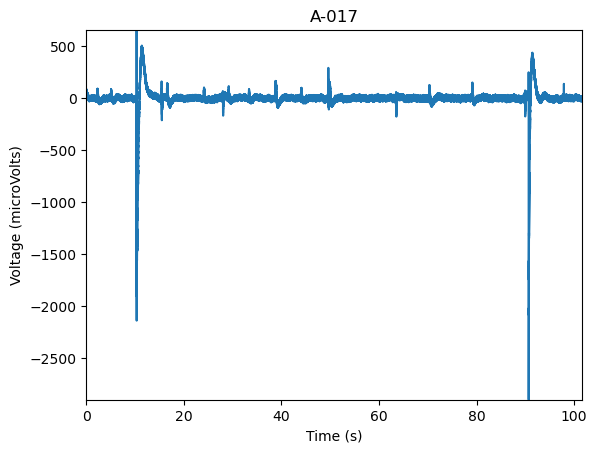

In [14]:
channel_name = 'A-017' # Change this variable and re-run cell to plot a different channel

%matplotlib inline

if data_present:
    plot_channel(channel_name, result)
    
else:
    print('Plotting not possible; no data in this file')